# E3 - basic ML
## 1. Importing and processing the data
The first step is to import and process the data. In this case we are starting with yeast_gene_tr.xls. This contains our target variable (TR (mol/min) dilution corrected) and the systematic names for all of our proteins. It does not, however, contain the sequences. The first task it to create a fasta file with headers containing the protein id and corresponding transcription rate for each entry.
<details>
<summary>Step 1: retrieving sequences</summary>
The first step I used was the uniprot id mapping tool. By setting it from gene name to uniprotKB and restricting to Saccharomyces cerevisiae we can get the sequences of all the genes in the uniprot database. I did this by searching for all the systematic names and gene names, since we can remove the duplicates later. We can download the sequences as a fasta file. The next step is to add our transcription rates to the headers.
</details>


<details>
<summary>Step 2: formatting fasta file</summary>
With the previously made fasta file we need to remove the duplicates and rewrite the header to be gene_name|transcription_rate. Try to do this in python (feel free to google and use chat gpt). The solution I came to is below. Essentially reading the 
</details>


In [1]:
# change to split header and make dictionary for gene name. Append TR as entry in dictionary

import pandas as pd

def extract_gn(string):
    # Find the index of 'GN=' in the string
    gn_index = string.find('GN=')
    if gn_index != -1:  # If 'GN=' is found
        # Extract the substring starting from 'GN='
        gn_substr = string[gn_index:]
        # Split the substring by spaces and get the first part after 'GN='
        gn_value = gn_substr.split(' ')[0][3:]
        return gn_value
    else:
        return "no_gene_name"


def get_tr_value(csv_file, gene_name):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file)
    
    # Look for the gene name in either 'Sistematic name' or 'gene name' column
    mask = (df['Sistematic name'] == gene_name) | (df['Gene name'] == gene_name)
    filtered_df = df[mask]
    
    # If any matching rows are found, return the TR (mol/min) dilution corrected
    if not filtered_df.empty:
        tr_value = filtered_df.iloc[0]['TR (mol/min) dilution corrected']
        return tr_value
    else:
        return None


def remove_duplicates(input_file, output_file):
    sequences = {}
    
    # Read the input FASTA file
    with open(input_file, 'r') as f:
        current_sequence = ''
        current_gene = ''
        for line in f:
            if line.startswith('>'):
                if current_sequence:
                    sequences[current_gene] = current_sequence
                    current_sequence = ''
                current_gene = extract_gn(line.strip())
            else:
                current_sequence += line.strip()
        # Add the last sequence
        sequences[current_gene] = current_sequence
    
    # Write unique sequences to the output FASTA file
    with open(output_file, 'w') as out:
        for header, sequence in sequences.items():
            if get_tr_value("yeast_gene_tr.csv", header) != None and str(get_tr_value("yeast_gene_tr.csv", header)) != "nan":
                out.write(">"+header + "|" + str(get_tr_value("yeast_gene_tr.csv", header)) + '\n')
                out.write(sequence + '\n')

# Usage
input_file = 'unprocessed.fasta'
output_file = 'processed.fasta'
#remove_duplicates(input_file, output_file)


/tmp/ipykernel_21354/3902861780.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## 2. One-hot encoding protein data

In [2]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Step 1: Parse the FASTA file to get sequence array and target variable
def parse_fasta(file_path):
    sequences = []
    targets = []
    sequence = []
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line.startswith('>'):
                if sequence:
                    sequences.append(sequence)
                sequence = []
                targets.append(float(line.strip().split('|')[1]))
            else:
                for aa in line:
                    sequence.append(aa)
        sequences.append(sequence)
    max_length = max(len(protein) for protein in sequences)
    sequence_array = [protein + ['na'] * (max_length - len(protein)) for protein in sequences]
    sequence_array = np.array(sequence_array)
    return sequence_array, targets

# Step 2: One-hot encode the protein sequences
enc = OneHotEncoder(handle_unknown='ignore')


sequences, targets = parse_fasta('processed.fasta')
one_hot_sequences = enc.fit_transform(sequences, targets)


In [3]:
from sklearn.model_selection import train_test_split

train_sequences, test_sequences, train_targets, test_targets = train_test_split(one_hot_sequences, targets, train_size=0.8, random_state=42)

In [10]:
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

pca = PCA(n_components=100, svd_solver='arpack')
pca_train_sequences = pca.fit_transform(train_sequences)

tsvd = TruncatedSVD(n_components=100, algorithm='arpack')
tsvd_train_sequences = tsvd.fit_transform(train_sequences)

In [17]:
tsne = TSNE(n_components=3, random_state=42)
tsne_train_sequences = tsne.fit_transform(tsvd_train_sequences)

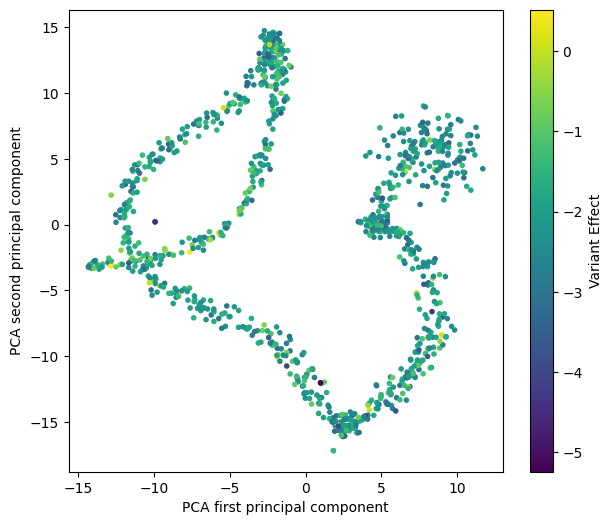

In [20]:
import matplotlib.pyplot as plt

fig_dims = (7, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(tsne_train_sequences[:,0], tsne_train_sequences[:,1], c=np.log(train_targets), marker='.')
ax.set_xlabel('PCA first principal component')
ax.set_ylabel('PCA second principal component')
plt.colorbar(sc, label='Variant Effect')

In [25]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(tsvd_train_sequences, train_targets)
knn.score(tsvd_train_sequences, train_targets)

0.23535078410118526